In [37]:
import pandas as pd
import json
import asyncio
import aiohttp
import numpy as np
import datetime
from pandas.api.types import is_numeric_dtype
from matplotlib import pyplot as plt
from matplotlib import dates
from scipy.special import logit

import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
sns.set()


In [ ]:

samp_urls = [f'https://paperswithcode.com/api/v1/evaluations/?items_per_page=100&page={page}' for page in np.arange(1,100)]

# samps = await get_samps(samp_urls)
samps = pd.concat([pd.DataFrame(s) for s in samps])

In [ ]:
# Do this asnchronously to save a lot of time

# Result is already saved in this dir

"""
urls = [f'https://paperswithcode.com/api/v1/evaluations/{evaluation["id"]}/results/' 
        for _, evaluation in samps.iterrows()]

async def get(url, session):
    try:
        async with session.get(url=url) as response:
            resp = await response.json()
            if 'results' in resp:
                return resp['results']
    except Exception as e:
        print("Unable to get url {} due to {}.".format(url, e.__class__))
        
async def get_samps(urls):
    async with aiohttp.ClientSession() as session:
        ret = await asyncio.gather(*[get(url, session) for url in urls])
    print("Finalized all. Return is a list of len {} outputs.".format(len(ret)))
    return ret

evaluations = await get_samps(urls)

with open('evaluations500.json','w') as outfile:
    json.dump(evaluations,outfile)
"""

In [31]:
# Read and preprocess evaluations

with open('evaluations500.json','r') as infile:
    evaluations = json.load(infile)

evaluations = [pd.json_normalize(ev) for ev in evaluations if ev and len(ev)>1]

normed = 0

# Function to convert all the metrics to floats

def to_float(s):
    if is_numeric_dtype(s):
        return s
    s = s.astype(str)
    if '%' in s.loc[0]:
        return s.str.rstrip('%').astype(float)/100
    else:
        try:
            return s.str.replace('-','NaN').str.replace('None','NaN').astype(float)
        except ValueError:
            x = np.zeros(len(s))
            x = float('NaN')
            return x

# Pick a "best metric" for all evaluations
# cast metric values to float
# and dates to datetimes
        
for ev in evaluations:
    if ev.loc[0,'best_metric']=='None' or ev.loc[0,'best_metric']==None:
        ev.loc[:,'best_metric'] = ev.columns[ev.columns.str.contains('metric.')][0][8:]
    else:
        ev.loc[:,'best_metric'] = ev.loc[0,'best_metric']
    bm = 'metrics.'+ev.loc[0,'best_metric']
    try:
        ev[bm] = to_float(ev[bm])
    except (KeyError, ValueError):
        ev[bm] = np.nan
    ev['evaluated_on'] = pd.to_datetime(ev.loc[:,'evaluated_on'])
    
# Drop evaluations where "best metric" values are missing    

evaluations = [ev.dropna(subset=['metrics.' + ev.loc[0,'best_metric'], 'evaluated_on']).reset_index(drop=True) 
               for ev in evaluations if len(ev.dropna(subset=['metrics.' + ev.loc[0,'best_metric'], 'evaluated_on'])) > 0]


In [33]:
"""

Lots of different metrics, most of them 0-1 (or 0%-100%) valued

We won't distinguish between 0-1 and 0%-100%, we'll just infer it from the values

Accuracy - (0-1)
Score - could be many things, presumably - (maybe/maybe not 0-1)
F1 - harmonic mean of precision and recall (0-1) https://en.wikipedia.org/wiki/F-score
PSNR - peak signal to noise (not 0-1) is one exception
mAP - mean Average Precision (0-1)
mIoU - Jaccard index (0-1)
top-1 Accuracy - 0-1
FID - Frechet inception distance (not 0-1) https://en.wikipedia.org/wiki/Fréchet_inception_distance
AP - average precision (0-1)
MAP - mean average precision? (0-1)
Mean IoU - Jaccard index (0-1)
AUC - area under ROC (0-1)
Median win rate - (0-1)
Accuracy (%) - (0-1)
Top 1 Accuracy - 0-1
MAE - mean absolute error (not 0-1, unless normalised)
ROUGE-1 - star wars episode (0-1) https://en.wikipedia.org/wiki/ROUGE_(metric)
Percentage error - (0-1)
Average MPJPE (mm) - mean per joint position error (not 0-1) 
 https://github.com/cbsudux/Human-Pose-Estimation-101#mean-per-joint-position-error---mpjpe
Top-1 Error rate - (0-1)

For the rest, we're just going to guess

"""

bad_metrics = ['PSNR', 'Average MPJPE (mm)', 'FID', 'Score']

metrics = pd.concat([ev['best_metric'] for ev in evaluations])

print(metrics.value_counts().sort_values(ascending=False).head(20))

print('Number of metrics:', len(metrics.unique()))

evaluations = [ev for ev in evaluations if ev.loc[0,'best_metric'] not in bad_metrics]
print('Number of evaluations:', len(evaluations))

Accuracy              3392
Score                 2163
F1                    1117
PSNR                  1043
mAP                   1029
mIoU                   841
Top-1 Accuracy         780
FID                    688
AP                     625
MAP                    555
Mean IoU               486
AUC                    481
Median Win Rate        428
Accuracy (%)           386
Top 1 Accuracy         380
MAE                    354
ROUGE-1                334
Percentage error       318
Average MPJPE (mm)     317
Top-1 Error Rate       266
Name: best_metric, dtype: int64
Number of metrics: 782
Number of evaluations: 4012


In [ ]:
# Plot the best scores from the remaining evaluations

# Most are either 0-1 or 0%-100%

# We're going to remove anything greater than 100, and divide anything greater than 1 by 100

# Note that this is going to misclassify a smallish number of percentage measures

def best_score(evaluation_list):

    bm = 'metrics.' + evaluation_list.loc[0,'best_metric']
    
    p = parity(evaluation_list)
      
    best = evaluation_list.iloc[(p*evaluation_list[bm]).argmax()]
        
    return pd.DataFrame({'date':[best['evaluated_on']],
                         'best_score':[best[bm].max()],
                         'metric':[evaluation_list.loc[0,'best_metric']]})


n = pd.concat([best_score(ev) for ev in evaluations]).dropna().reset_index(drop=True)
n['fake_date'] = dates.datestr2num(n['date'].astype(str))

f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale="log")
sns.scatterplot(n,x='fake_date',y='best_score',ax=ax)
plt.savefig('score_distribution.png')

In [34]:


# PWC data is ordered by ranking
# we can infer metric parity from this
        
def parity(evaluation_list):
    try:
        bm = 'metrics.' + evaluation_list.loc[0,'best_metric']
    except KeyError:
        print(evaluation_list)
    d_idx = evaluation_list[bm]!=evaluation_list.loc[0,bm]
    if d_idx.sum():
        delta = evaluation_list.loc[0,bm]-evaluation_list[bm][d_idx].iloc[0]
    else:
        return 1
    if delta > 0:
        return 1
    return -1

# Transform scores according to parity

def parity_transform(v,p):
    if p == -1:
        return 1-v
    return v

# Remove scores above 100 and below zero, and scale the rest to sit 
# between 0 and 1

def clip_and_norm(evaluation_lists):
    
    out = []
    
    for evlist in evaluation_lists:

        bm = 'metrics.' + evlist.loc[0,'best_metric']

        if len(evlist) < 2:
            continue

        if evlist[bm].max() >= 100:
            continue

        if evlist[bm].min() <= 0:
            continue

        if evlist[bm].max() >= 1:
            evlist[bm] /= 100
            
        p = parity(evlist)

        evlist[bm] = logit(parity_transform(evlist[bm],p))
    
        out.append(evlist)
    
    return out

if not normed:
    evaluations = clip_and_norm(evaluations)
    normed = 1

In [43]:




def dscore_dt(evaluation_list,n,today='2022-11-01',cutoff=6,popularity=1):
    
    # If the benchmark is too recent, then we can't properly evaluate it
    
    if len(evaluation_list) < popularity:
        return np.nan
    
    l_cutoff = 30*cutoff
    cutoff = pd.to_datetime(today) - pd.Timedelta(f"{l_cutoff} days")
    if cutoff < evaluation_list['evaluated_on'].min():
        return np.nan
        
    l = 30*n
    bm = 'metrics.' + evaluation_list.loc[0,'best_metric']
    early = evaluation_list[evaluation_list['evaluated_on']<=
                            (evaluation_list['evaluated_on'].min() + pd.Timedelta(f"{l} days"))]
    if len(early) < 2:
        return 0

    p = parity(evaluation_list)

    best = early.iloc[(p*early[bm]).argmax()]
    first = early.iloc[early['evaluated_on'].argmin()]

    last = early.iloc[early['evaluated_on'].argmax()]
    delta_score = p*(best[bm]-first[bm])
    return delta_score



        
        

def t_month_progress(evlist, t=6, today='2022-11-01',early_cutoff='2010-01-01',end_cut=None):
    bm = 'metrics.' + evlist.loc[0,'best_metric']
    l = t*30
    first = evlist.iloc[evlist['evaluated_on'].argmin()]
    
    if end_cut:
        cutoff = pd.to_datetime(end_cut)
    else:
        cutoff = pd.to_datetime(today) - pd.Timedelta(f"{l} days")
    early_cutoff = pd.to_datetime(early_cutoff)

    if (cutoff < first['evaluated_on']) or (early_cutoff > first['evaluated_on']):
        return pd.DataFrame({
            'time_to_partial':[np.nan],
            'start_date':[first['evaluated_on']],
            'start_logit':[np.nan],
            'popularity':[np.nan]})


    ev = evlist[evlist['evaluated_on']<=(first['evaluated_on']+pd.Timedelta(f'{l} days'))]
    m = ev[bm].max()
    delta = m-first[bm]
    if delta>5:
        # There are two data points here going from AUC 0.01 -> 0.85 in 1 month
        # Initial submission seems like it had an error
        return pd.DataFrame({
            'time_to_partial':[np.nan],
            'start_date':[first['evaluated_on']],
            'start_logit':[np.nan],
            'popularity':[len(ev)]
        })

    return pd.DataFrame({
        'logit_progress':[delta],
        'start_date':[first['evaluated_on']],
        'start_logit':[first[bm]],
        'popularity':[len(ev)]
    })



    
def d_progress_dt(evlist, today='2022-11-01',early_cutoff='2010-01-01'):
    cutoff = pd.to_datetime(today)
    early_cutoff = pd.to_datetime(early_cutoff)
    first = evlist.iloc[evlist['evaluated_on'].argmin()]
    last = evlist['evaluated_on'].max()

    if (cutoff < first['evaluated_on']) or (early_cutoff > last):
        return pd.DataFrame({
            'dp_dt':[np.nan],
            'date':[np.nan],
            'start_logit':[np.nan],
            'popularity':[np.nan]
        })
    
    bm = 'metrics.' + evlist.loc[0,'best_metric']
    d_t = evlist.sort_values(by=bm,ascending=False)['evaluated_on'].diff().apply(lambda x: x.days)
    d_progress = evlist.sort_values(by=bm,ascending=False)[bm].diff()
    
    dict_out = {
        'dp_dt':d_progress[d_t<0]/d_t[d_t<0],
        'date':evlist['evaluated_on'][d_t<0],
        'start_logit':np.array([first[bm]]*len(d_progress))[d_t<0],
        'popularity':np.array([len(evlist)]*len(d_progress))[d_t<0]
    }
    return pd.DataFrame(dict_out).dropna()


def map_to_dataframe(evlists, f, date_col='start_date', **kwargs):
    out = pd.concat([f(ev,**kwargs) for ev in evlists]).reset_index(drop=True)
    out=out.dropna(subset=date_col)
    out['fake_date'] = dates.datestr2num(out[date_col].astype(str))
    date_series = np.linspace(out['fake_date'].min(),out['fake_date'].max(),10)
    date_labels = [datetime.date.strftime(d,'%Y-%m-%d') for d in dates.num2date(date_series)]
    
    return out, date_series, date_labels

def plot_dataframe(df,
                   date_series,
                   date_labels,
                   plot_func = sns.regplot,
                   y='logit_progress', 
                   xlim=None,
                   ylabel=None,
                   xlabel='Date on which benchmark was introduced',
                   ylim=None,
                   filename=None,
                   title=None,
                   logy=False,
                   **kwargs):
    fig, ax = plt.subplots(figsize=(7,7))
    plot_func(df,
                x='fake_date',
                y=y,
                ax=ax,
                **kwargs
               )
    ax.set_xticks(date_series,date_labels)
    if ylim:
        ax.set_ylim(ylim)
    if xlim:
        ax.set_xlim([dates.datestr2num(x) for x in xlim])
    if title:
        ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if logy:
        ax.set_yscale('log')
    
    if filename:
        plt.savefig(filename)
    
    return fig, ax

def lagged_correlations(evaluations, lags, early_cutoff='2010-01-01', end_cut=None, extra_args=''):
    outputs = []
    pgs = []

    for lag in lags:
        pg, date_series, date_labels = map_to_dataframe(evaluations,t_month_progress,t=lag,
                                                        early_cutoff='2010-01-01', end_cut=end_cut)
        outputs.append(smf.ols(f'logit_progress ~ fake_date + start_logit {extra_args}', data=pg).fit())
        pgs.append(pg)
    
    return outputs, pgs

def plot_correlations(lags, pgs, outputs, title):
    fig,ax = plt.subplots(figsize=(7,7))
    s = pd.DataFrame({
        'time_lag':lags,
        'coefficient':[1/(365*o.params['fake_date']/pgs[i]['logit_progress'].mean()) 
                       for i, o in enumerate(outputs)],
        })
    yerr = np.array([np.abs(s.loc[i,'coefficient'] - 1/(365*o.conf_int(0.1).loc['fake_date']/pgs[i]['logit_progress'].mean())) 
            for i, o in enumerate(outputs)])[:,::-1].T
    ax.errorbar(s['time_lag'],s['coefficient'],yerr=yerr,fmt='bo')
    ax.set_ylim([0,60])
    ax.set_ylabel('Years to double progress')
    ax.set_xlabel('window size (months)')
    ax.set_title('Pre 2010 cutoff, adjusted for initial score but not popularity')
    plt.savefig(title.lower().replace(" ","_") + '.png')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         logit_progress   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     25.84
Date:                Sat, 28 Jan 2023   Prob (F-statistic):           7.36e-12
Time:                        10:43:07   Log-Likelihood:                -1759.0
No. Observations:                3277   AIC:                             3524.
Df Residuals:                    3274   BIC:                             3542.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0961      0.173     -0.557      0.578      -0.435       0.242
fake_date    1.652e-05   9.67e-06      1.709      0.088   -2.44e-06    3.55e-05
start_logit    -0.0294      0.004     -7.031      0.000      -0.038      -0.021
==============================================================================
Omnibus:                     2681.296   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59913.378
Skew:                           3.874   Prob(JB):                         0.00
Kurtosis:                      22.462   Cond. No.                     4.26e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

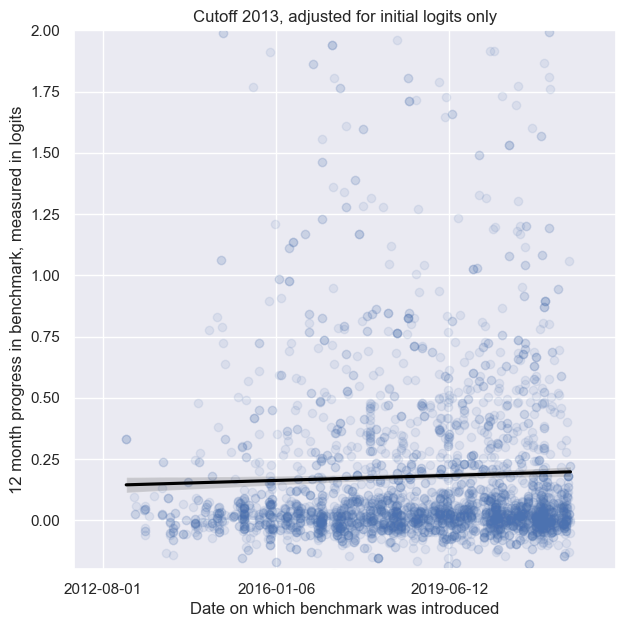

In [38]:


progress, date_series, date_labels = map_to_dataframe(evaluations,t_month_progress,t=12,early_cutoff='2013-01-01')

fig, ax = plot_dataframe( 
    progress,
    date_series,
    date_labels,
    ylabel='12 month progress in benchmark, measured in logits',
    filename='12_month_window_cutoff_2013_no_pop_init.png',
    xlim=['2012-01-01','2022-10-01'],
    scatter_kws={'alpha':0.1},
    line_kws={"color": "black"},
    ci=90,
    y_partial='start_logit',
    title='Cutoff 2013, adjusted for initial logits only',
    ylim=[-0.2,2]
    )
ols = smf.ols('logit_progress ~ fake_date + start_logit', data=progress).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         logit_progress   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     54.19
Date:                Thu, 24 Nov 2022   Prob (F-statistic):           8.79e-24
Time:                        21:40:21   Log-Likelihood:                -2172.0
No. Observations:                2589   AIC:                             4350.
Df Residuals:                    2586   BIC:                             4367.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.4366      0.294     -1.485      0.138      -1.013       0.140
fake_date    4.953e-05   1.67e-05      2.967      0.003    1.68e-05    8.23e-05
start_logit    -0.0647      0.006    -10.015      0.000      -0.077      -0.052
==============================================================================
Omnibus:                     1306.540   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8470.835
Skew:                           2.346   Prob(JB):                         0.00
Kurtosis:                      10.518   Cond. No.                     4.71e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

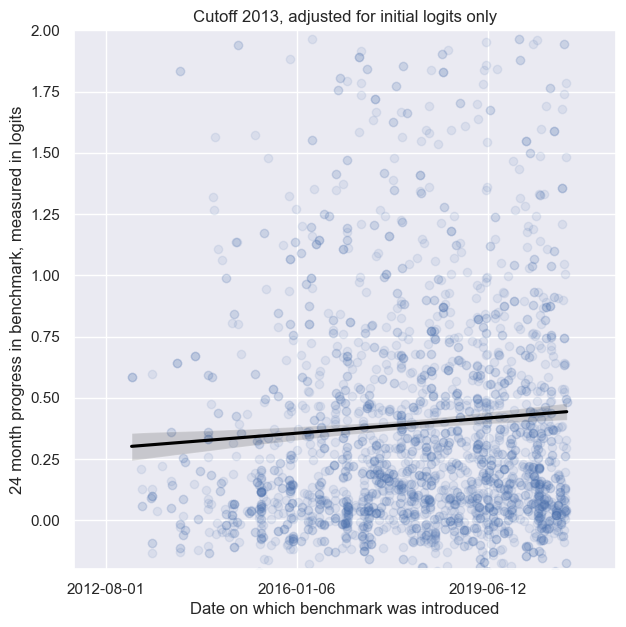

In [1303]:

progress, date_series, date_labels = map_to_dataframe(evaluations,t_month_progress,t=24,early_cutoff='2013-01-01')

fig, ax = plot_dataframe( 
    progress,
    date_series,
    date_labels,
    ylabel='24 month progress in benchmark, measured in logits',
    filename='24_month_window_cutoff_2013_no_pop_init.png',
    xlim=['2012-01-01','2021-10-01'],
    scatter_kws={'alpha':0.1},
    line_kws={"color": "black"},
    ci=90,
    y_partial='start_logit',
    title='Cutoff 2013, adjusted for initial logits only',
    ylim=[-0.2,2]
    )
ols = smf.ols('logit_progress ~ fake_date + start_logit', data=progress).fit()
ols.summary()

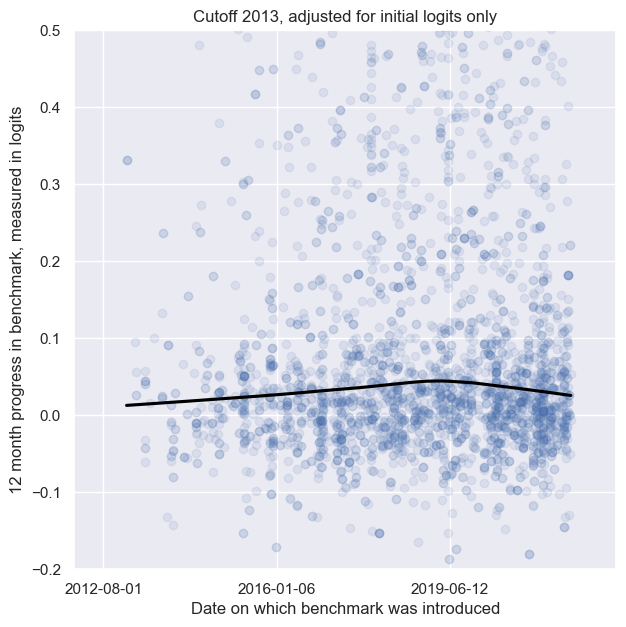

In [1342]:
progress, date_series, date_labels = map_to_dataframe(evaluations,t_month_progress,t=12,early_cutoff='2013-01-01')

fig, ax = plot_dataframe( 
    progress,
    date_series,
    date_labels,
    ylabel='12 month progress in benchmark, measured in logits',
    filename='12_month_window_cutoff_2013_no_pop_init_lowess.png',
    xlim=['2012-01-01','2022-10-01'],
    scatter_kws={'alpha':0.1},
    line_kws={"color": "black"},
    ci=90,
    y_partial='start_logit',
    title='Cutoff 2013, adjusted for initial logits only',
    ylim=[-0.2,0.5],
    lowess=True
    )

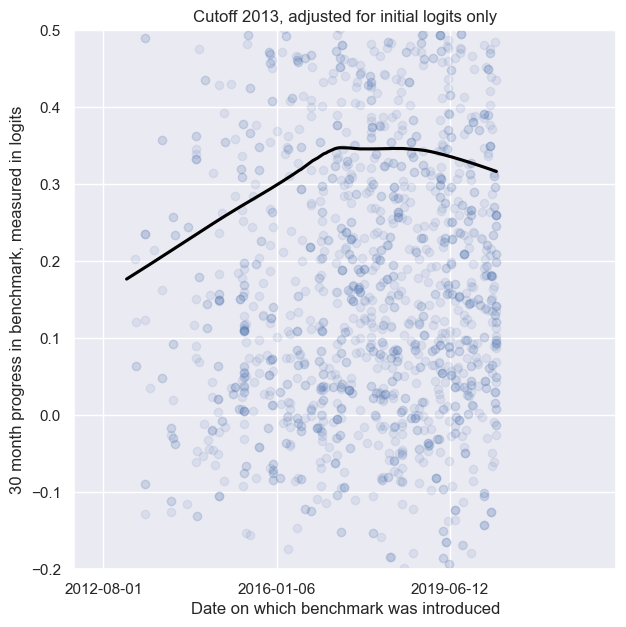

In [1344]:
progress, date_series, date_labels = map_to_dataframe(evaluations,t_month_progress,t=30,early_cutoff='2013-01-01')

fig, ax = plot_dataframe( 
    progress,
    date_series,
    date_labels,
    ylabel='30 month progress in benchmark, measured in logits',
    filename='30_month_window_cutoff_2013_no_pop_init_lowess.png',
    xlim=['2012-01-01','2022-10-01'],
    scatter_kws={'alpha':0.1},
    line_kws={"color": "black"},
    ci=90,
    y_partial='start_logit',
    title='Cutoff 2013, adjusted for initial logits only',
    ylim=[-0.2,0.5],
    lowess=True
    )

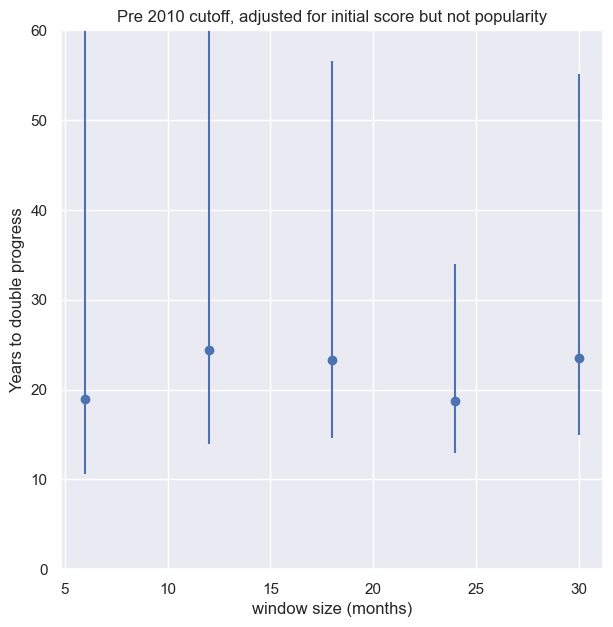

In [42]:
lags = 6*np.arange(1,6)

outputs_nopop, pgs = lagged_correlations(evaluations, lags)

plot_correlations(lags, pgs, outputs_nopop, 'Pre 2010 cutoff, adjusted for initial score but not popularity')

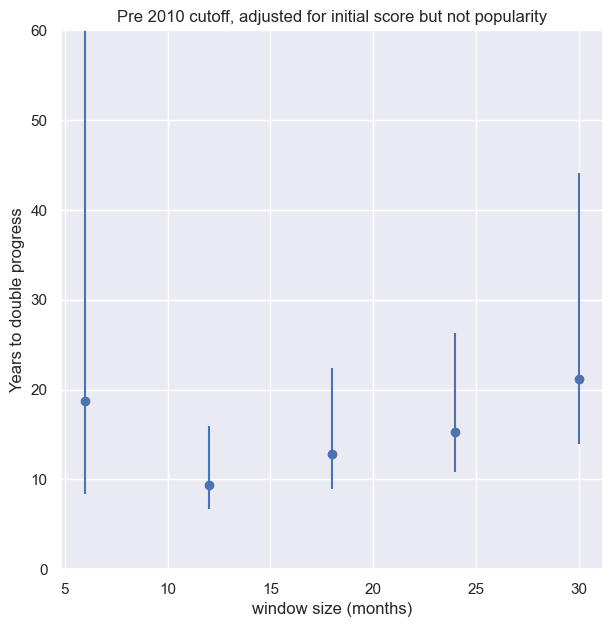

In [44]:

outputs_nopop, pgs = lagged_correlations(evaluations, lags, end_cut='2020-05-01')

plot_correlations(lags, pgs, outputs_nopop, 'Post April 2020 cutoff, pre 2010 cutoff, adjusted for initial score but not popularity')

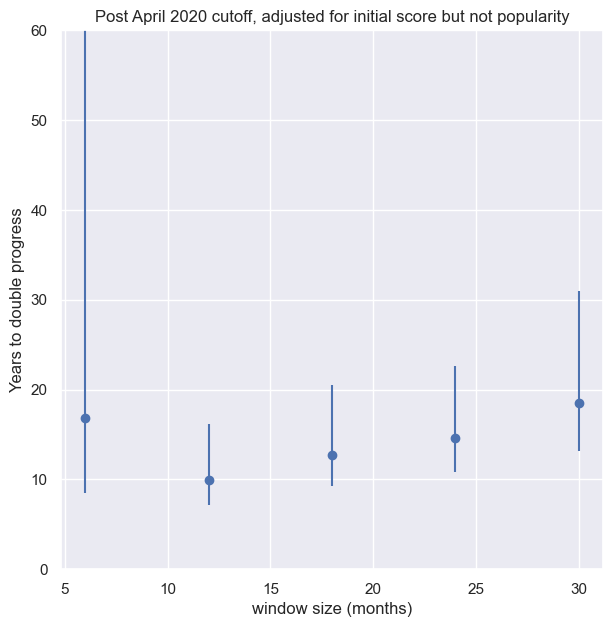

In [1345]:
outputs_nopop, pgs = lagged_correlations(evaluations, lags, end_cut='2020-05-01')

plot_correlations(lags, pgs, outputs_nopop, 
                  'Post April 2020 cutoff, pre 2010 cutoff, adjusted for initial score but not popularity')

"Post April 2020 cutoff, adjusted for initial score but not popularity"

outputs_nopop = []
pgs = []

for lag in lags:
    pg, date_series, date_labels = map_to_dataframe(evaluations,t_month_progress,t=lag,early_cutoff='1900-01-01',end_cut='2020-05-01')
    outputs_nopop.append(smf.ols('logit_progress ~ fake_date + start_logit', data=pg).fit())
    pgs.append(pg)

fig,ax = plt.subplots(figsize=(7,7))
s = pd.DataFrame({
    'time_lag':lags,
    'coefficient':[1/(365*o.params['fake_date']/pgs[i]['logit_progress'].mean()) 
                   for i, o in enumerate(outputs_nopop)],
    })
yerr = np.array([np.abs(s.loc[i,'coefficient'] - 1/(365*o.conf_int(0.1).loc['fake_date']/pgs[i]['logit_progress'].mean())) 
        for i, o in enumerate(outputs_nopop)])[:,::-1].T
ax.errorbar(s['time_lag'],s['coefficient'],yerr=yerr,fmt='bo')
ax.set_ylabel('Years to double progress')
ax.set_xlabel('window size (months)')
ax.set_ylim([0,60])
ax.set_title('Post April 2020 cutoff, adjusted for initial score but not popularity')
plt.savefig('2019_late_cutoff_coefficients_nopop_ytd.png')